<a href="https://colab.research.google.com/github/tancredew/ObesityData/blob/main/DSRP_Obesity_Data(Jul30_2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Research Question: What behavioral and physiological patterns define distinct risk profiles for obesity in young adults, and how can unsupervised clustering reveal subtypes beyond traditional obesity classifications?



Things completed thus far:


*   Data preprocessing
*   Linear regression
*   Decision tree
*   K-means clustering
*   Subgroup analysis by gender
*   K-Means clustering
    *   Developing cluster profiles



In [2]:
#SETUP

import pandas as pd

url = 'https://raw.githubusercontent.com/tancredew/ObesityData/main/ObesityDataSet_raw_and_data_sinthetic.csv'
df = pd.read_csv(url)
df.head()


Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [3]:
# demonstration by mentor, not part of my project
# from sklearn.preprocessing import LabelEncoder

# df_encoded = df.copy()
# label_encoder = LabelEncoder()

# for column in df_encoded.columns:
#     if df_encoded[column].dtype == 'object':
#         df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

# import seaborn as sns
# corr = df_encoded.corr()
# sns.heatmap(corr, annot=True)
# plt.show()



/tmp/ipython-input-4-2279800176.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="NObeyesdad", order=df["NObeyesdad"].value_counts().index, palette="Set2")


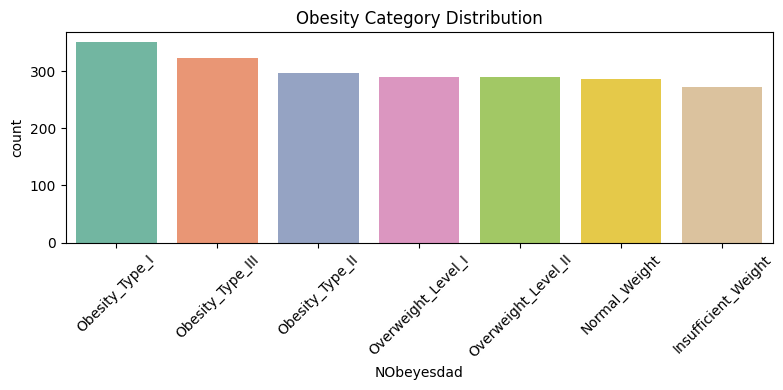

In [4]:
#visualization of the dataset for the lightning talk

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="NObeyesdad", order=df["NObeyesdad"].value_counts().index, palette="Set2")
plt.xticks(rotation=45)
plt.title("Obesity Category Distribution")
plt.tight_layout()
plt.show()


## **Data Preprocessing**

Before dropping duplicates: (2111, 17)
After dropping duplicates: (2087, 17)
Class distribution:
 NObeyesdad
Obesity_Type_I         0.168184
Obesity_Type_III       0.155247
Obesity_Type_II        0.142310
Overweight_Level_II    0.138955
Normal_Weight          0.135122
Overweight_Level_I     0.132247
Insufficient_Weight    0.127935
Name: proportion, dtype: float64
Data shape after removing outliers: (2063, 17)
Number of potential outliers: 24


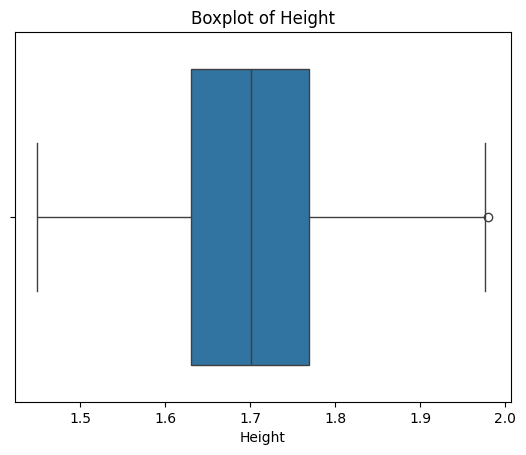

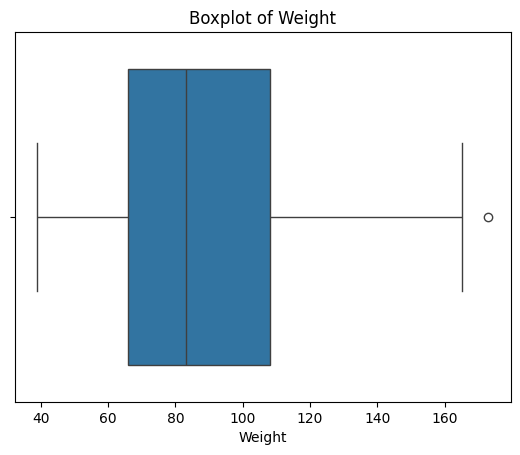

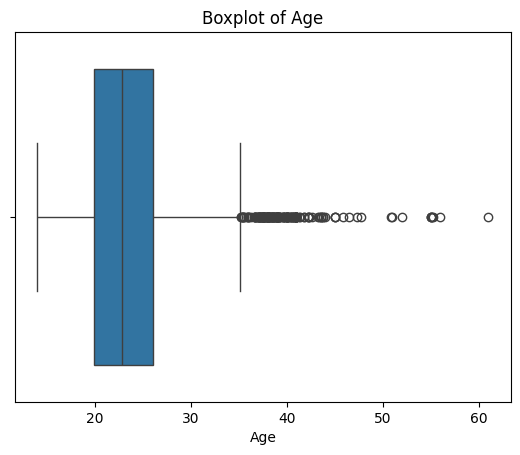

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# drop duplicates
print(f"Before dropping duplicates: {df.shape}")
df = df.drop_duplicates()
print(f"After dropping duplicates: {df.shape}")

# separate
target = "NObeyesdad"
X = df.drop(columns=[target])
y = df[target]

# check class balance
print("Class distribution:\n", y.value_counts(normalize=True))

# scale numeric features
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

#categoricals
X = pd.get_dummies(X, drop_first=True)

# stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# outlier inspection
outlier_cols = ["Height", "Weight", "Age"]
z_scores = np.abs(zscore(df[outlier_cols]))
outlier_mask = (z_scores > 3).any(axis=1)
df_clean = df[~outlier_mask].copy()
print(f"Data shape after removing outliers: {df_clean.shape}")

# print outliers
outliers = df[outlier_mask]
print(f"Number of potential outliers: {outliers.shape[0]}")

# boxplots
for col in outlier_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


## **Linear Regression Model**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.96        53
      Normal_Weight       0.84      0.81      0.82        57
     Obesity_Type_I       0.92      0.93      0.92        70
    Obesity_Type_II       0.94      0.98      0.96        60
   Obesity_Type_III       0.98      0.98      0.98        65
 Overweight_Level_I       0.80      0.80      0.80        55
Overweight_Level_II       0.83      0.74      0.78        58

           accuracy                           0.89       418
          macro avg       0.89      0.89      0.89       418
       weighted avg       0.89      0.89      0.89       418



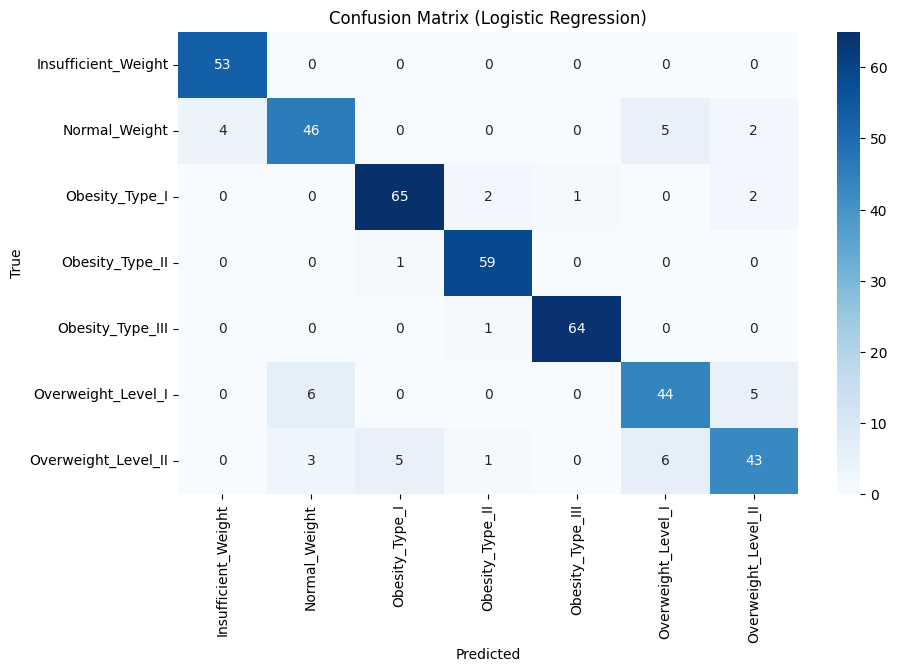

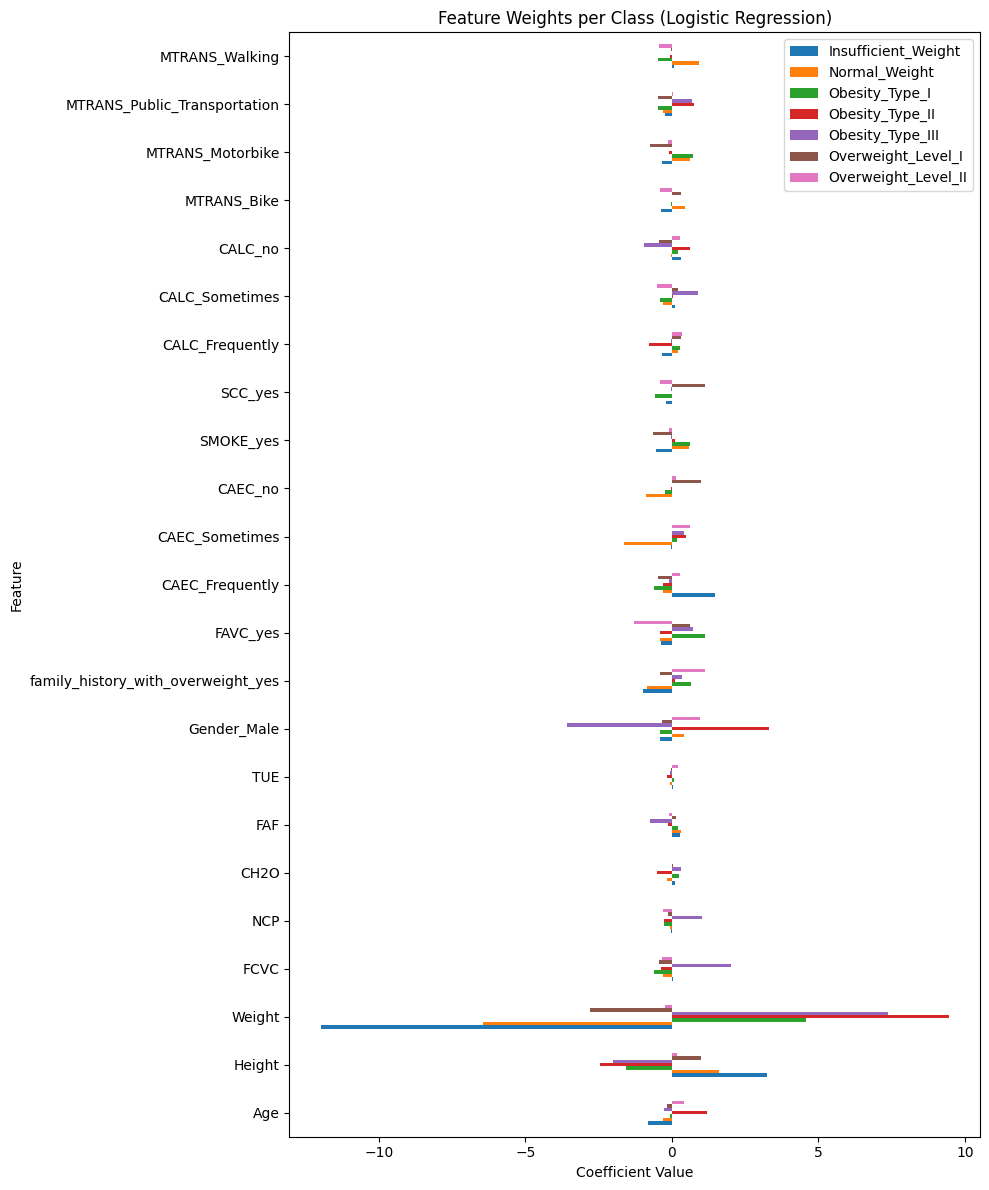

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# train logistic regression
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)

# predict
y_pred = log_reg.predict(X_test)

# evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=log_reg.classes_,
            yticklabels=log_reg.classes_)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# feature importance
coefs = pd.DataFrame(log_reg.coef_, columns=X.columns, index=log_reg.classes_)
coefs.T.plot(kind='barh', figsize=(10, 12), legend=True)
plt.title("Feature Weights per Class (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Main insights:
*   accuracy around 90 percent, does better than the decision tree especially on tricky classes like overweight and early obesity
*   key predictors are weight, height, CH2O, and FCVC
*   gender split shows females influenced more by FAF and family history, males by CH2O and transport habits
*   some mixups between normal weight and overweight, which makes sense for borderline cases
*   feature weights mostly line up with expectations like higher CH2O and lower FCVC pushing toward obesity classes

## **Decision Tree**

Decision Tree Classification Report:

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.94        53
      Normal_Weight       0.86      0.65      0.74        57
     Obesity_Type_I       0.84      0.61      0.71        70
    Obesity_Type_II       0.84      0.98      0.91        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.60      0.53      0.56        55
Overweight_Level_II       0.51      0.76      0.61        58

           accuracy                           0.78       418
          macro avg       0.80      0.78      0.78       418
       weighted avg       0.80      0.78      0.78       418



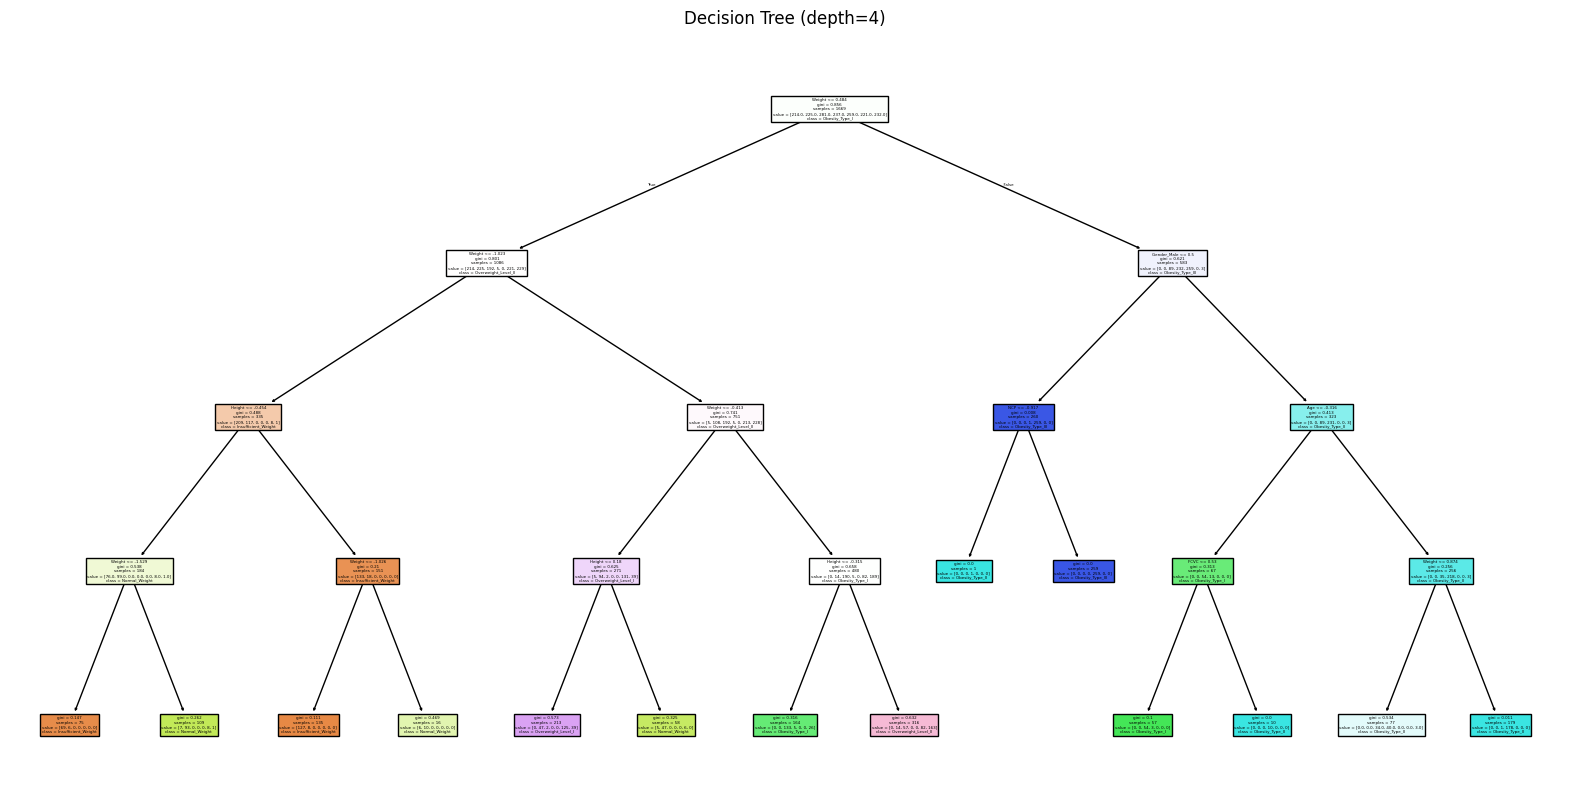

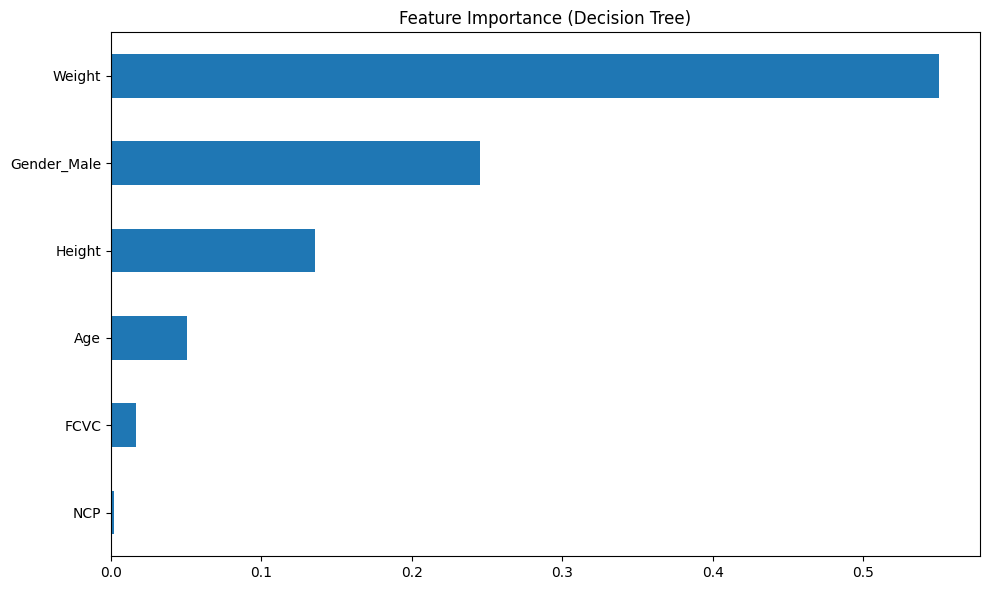

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# train decision tree
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# predict
y_pred_tree = tree.predict(X_test)

# evaluate
print("Decision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_tree))

# plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=tree.classes_)
plt.title("Decision Tree (depth=4)")
plt.show()

# feature importance
importances = pd.Series(tree.feature_importances_, index=X.columns)
importances = importances[importances > 0].sort_values()
importances.plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance (Decision Tree)")
plt.tight_layout()
plt.show()


Main insights:


*   most important features are weight, height, FCVC split early—basic physical + food habits
*   strong for extremes (nailed obesity III + underweight bc those cases are clear-cut)
*   mid classes were fuzzier
  *   confused/overlapped overweight I/II, normal, obesity I
  *   most mistakes were near neighbors (e.g. normal vs overweight I)
*   shallow tree (depth=4) still hit ~78% acc (simple rules worked decently)





## **Subgroup Analysis by Gender**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


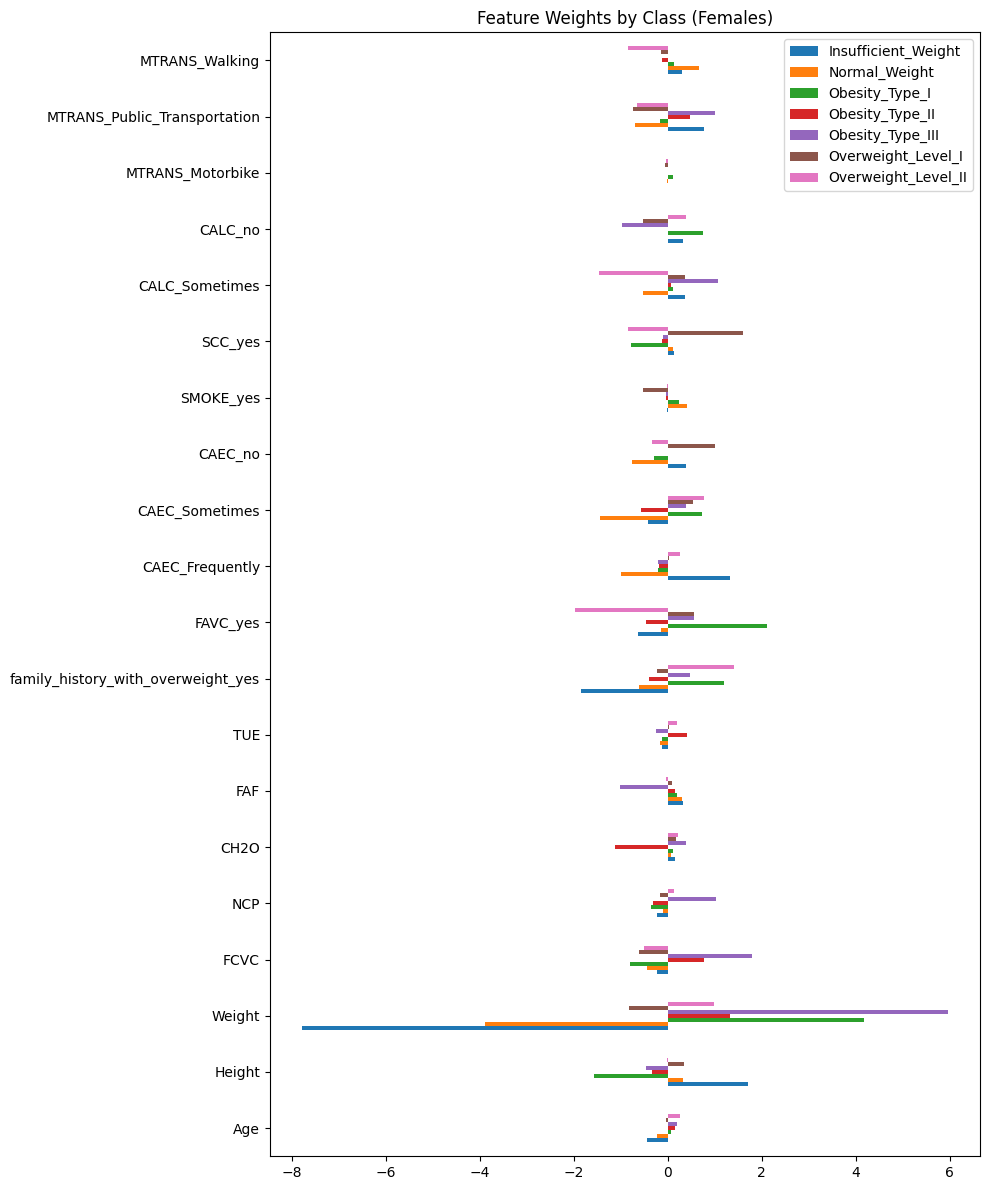

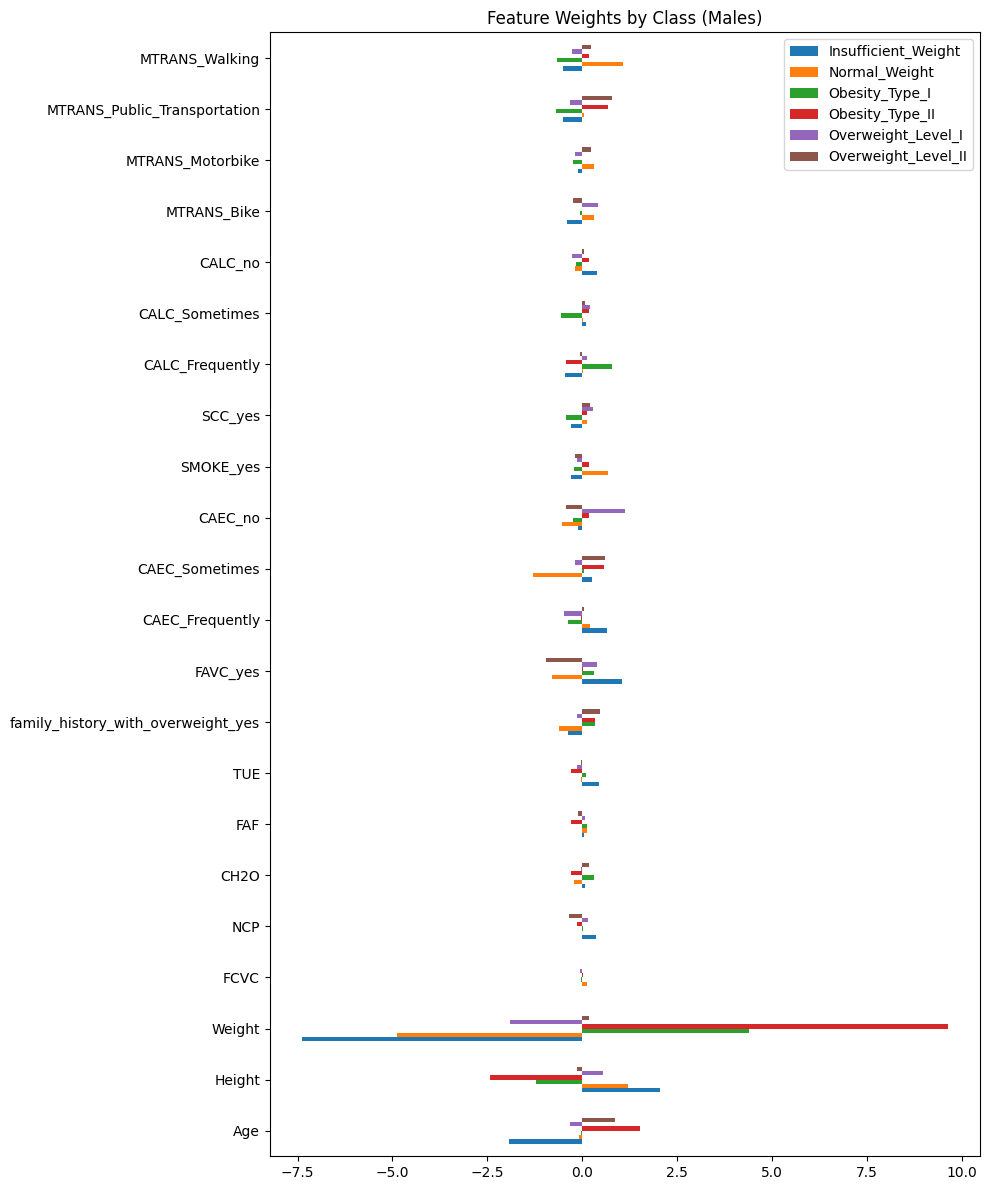

In [8]:
#SECTION 4 -- SUBGROUP ANALYSIS BY GENDER

# split by gender
df_female = df[df["Gender"] == "Female"]
df_male = df[df["Gender"] == "Male"]

# drop gender from features
X_female = df_female.drop(columns=["NObeyesdad", "Gender"])
X_male = df_male.drop(columns=["NObeyesdad", "Gender"])
y_female = df_female["NObeyesdad"]
y_male = df_male["NObeyesdad"]

# scale + encode
X_female = pd.get_dummies(X_female, drop_first=True)
X_male = pd.get_dummies(X_male, drop_first=True)
scaler = StandardScaler()
X_female[numerical_cols] = scaler.fit_transform(X_female[numerical_cols])
X_male[numerical_cols] = scaler.fit_transform(X_male[numerical_cols])

# drop rare classes in y_male (it caused a bunch of errors because the classes were too small)
class_counts = y_male.value_counts()
valid_classes = class_counts[class_counts >= 2].index
mask = y_male.isin(valid_classes)
X_male = X_male[mask]
y_male = y_male[mask]

# stratified split
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_male, y_male, stratify=y_male, test_size=0.2, random_state=42
)

# stratified train/test split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_female, y_female, stratify=y_female, test_size=0.2, random_state=42)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X_male, y_male, stratify=y_male, test_size=0.2, random_state=42)

# train separate models
log_female = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_female.fit(Xf_train, yf_train)

log_male = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_male.fit(Xm_train, ym_train)

# plot feature weights
female_coefs = pd.DataFrame(log_female.coef_, columns=Xf_train.columns, index=log_female.classes_)
male_coefs = pd.DataFrame(log_male.coef_, columns=Xm_train.columns, index=log_male.classes_)

female_coefs.T.plot(kind="barh", figsize=(10, 12), title="Feature Weights by Class (Females)")
plt.tight_layout()
plt.show()

male_coefs.T.plot(kind="barh", figsize=(10, 12), title="Feature Weights by Class (Males)")
plt.tight_layout()
plt.show()


Main insights:


*   Behavioral features (e.g. emotional eating, hydration) are more predictive for females -> implies lifestyle interventions may be more effective for them.
*   Height is negatively associated with obesity in males but not in females (possible biological or social sex differences?)
*   Transport mode (e.g. walking and public transportation) is much more protective for females --> activity level differences across daily routines can influence weight
*   Stress-driven eating & family history are stronger obesity predictors in females --> means it is important to know emotional/genetic context in female weight patterns



## **K-Means Clustering & Elbow Plot (7 Clusters)**

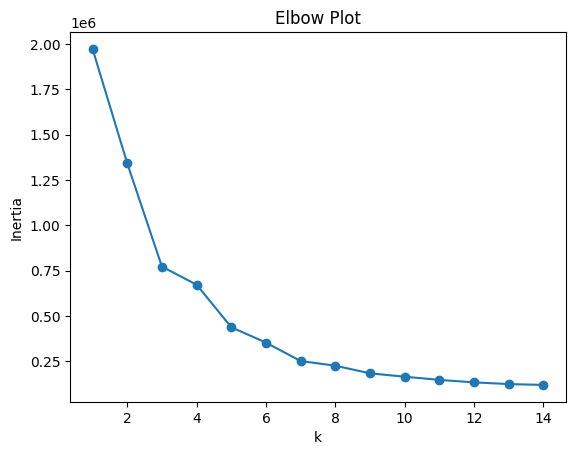

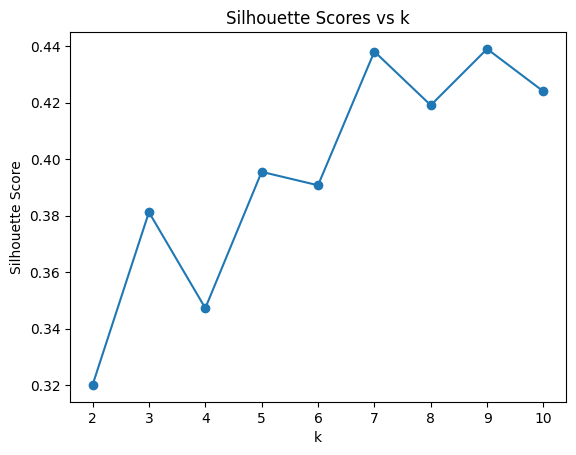

Cluster
2    430
1    366
5    356
0    332
6    273
3    187
4    143
Name: count, dtype: int64


In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# prepare data
X_scaled = df.drop(columns=["NObeyesdad"])
X_scaled = pd.get_dummies(X_scaled, drop_first=True)

# scale numeric features only
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
X_scaled[numerical_cols] = StandardScaler().fit_transform(X_scaled[numerical_cols])

#elbow plot (for determining ideal cluster group #)
inertias = []
for k in range(1, 15):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(1, 15), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

#k-means silhouette score plot (to verify)
from sklearn.metrics import silhouette_score
scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    scores.append(silhouette_score(X_scaled, km.labels_))

plt.plot(range(2, 11), scores, marker='o')
plt.title("Silhouette Scores vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()


# run k-means
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# attach cluster labels to df & prview
df["Cluster"] = clusters
print(df["Cluster"].value_counts())


## **Cluster Profile Plots by Variable**

['yes' 'no']
family_history_with_overweight
yes    1722
no      365
Name: count, dtype: int64


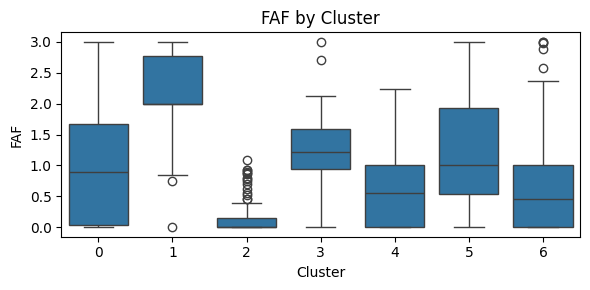

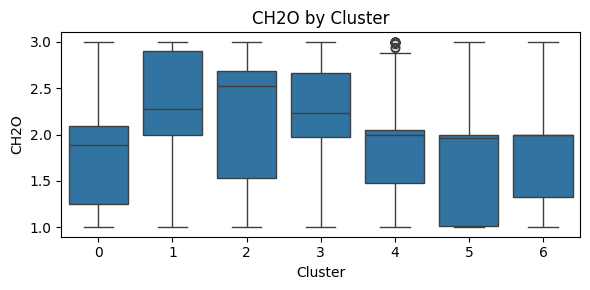

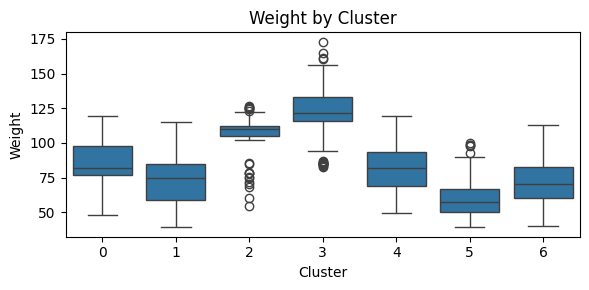

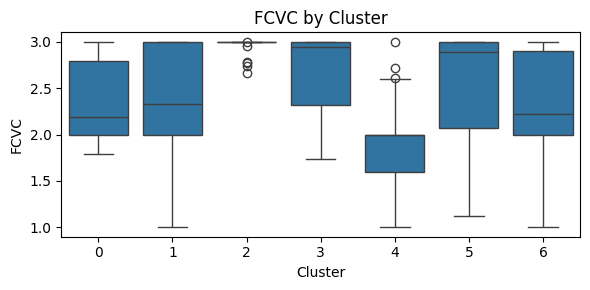

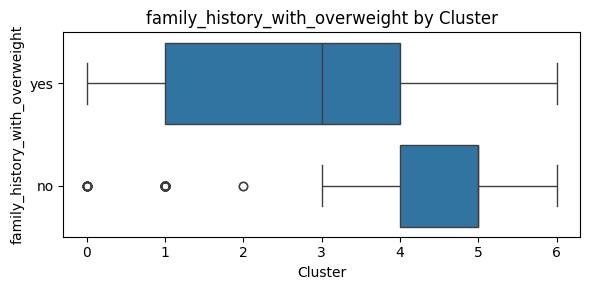

NObeyesdad  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Cluster                                                          
0                             2             14              84   
1                            88             62              41   
2                             0              6               0   
3                             0              0              59   
4                            46             64              78   
5                            90             88              26   
6                            41             48              63   

NObeyesdad  Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Cluster                                                             
0                        57                 0                  48   
1                         0                 0                  55   
2                         0               191                   0   
3                       159               133                   4   
4                        48                 0                  78   
5                         5                 0                  35   
6                        28                 0                  56   

NObeyesdad  Overweight_Level_II  
Cluster                          
0                            76  
1                            37  
2                             6  
3                            20  
4                            86  
5                            34  
6                            31

In [10]:
numeric_df = df.select_dtypes(include="number")
cluster_summary = numeric_df.groupby("Cluster").mean().round(2)
cluster_summary.T

print(df["family_history_with_overweight"].unique())
print(df["family_history_with_overweight"].value_counts(dropna=False))


import seaborn as sns
import matplotlib.pyplot as plt

key_vars = ["FAF", "CH2O", "Weight", "FCVC", "family_history_with_overweight"]

for var in key_vars:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, x="Cluster", y=var)
    plt.title(f"{var} by Cluster")
    plt.tight_layout()
    plt.show()

pd.crosstab(df["Cluster"], df["NObeyesdad"])



## **Cluster Profile Correlation Matrices**

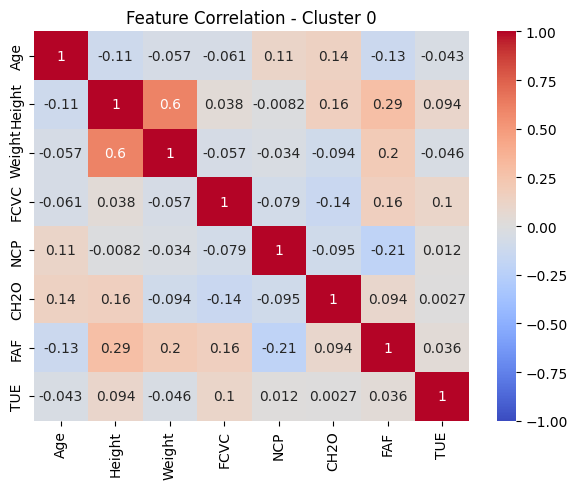

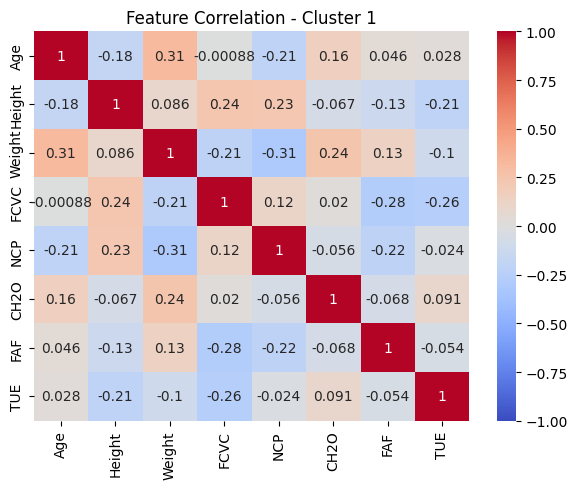

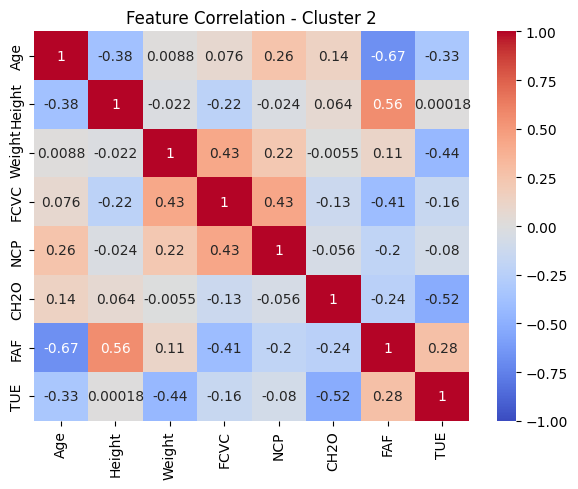

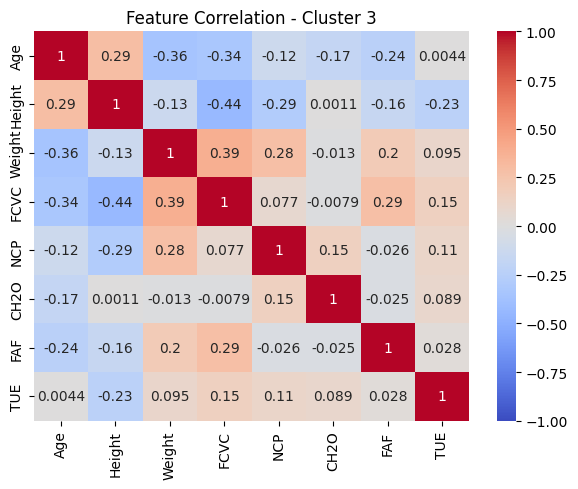

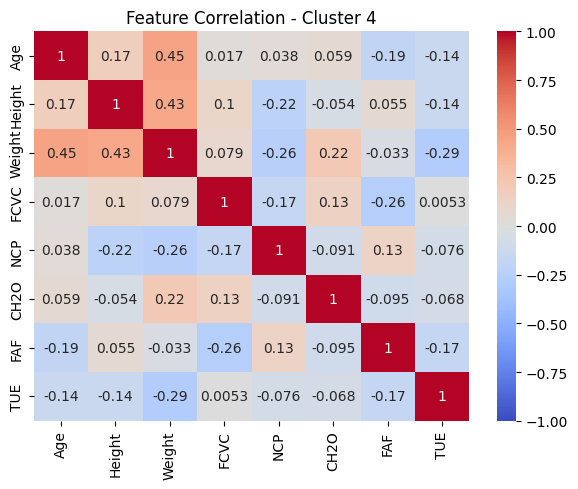

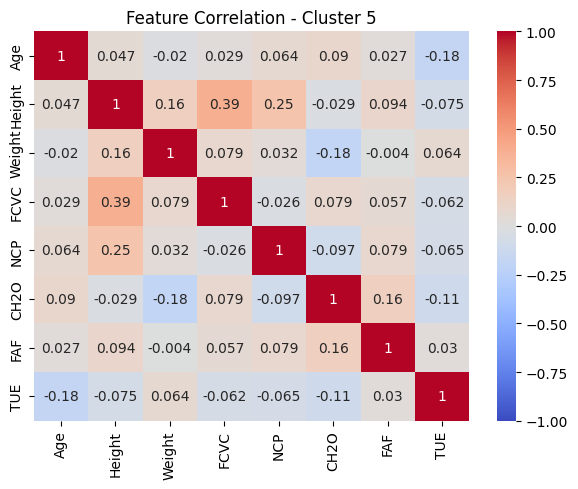

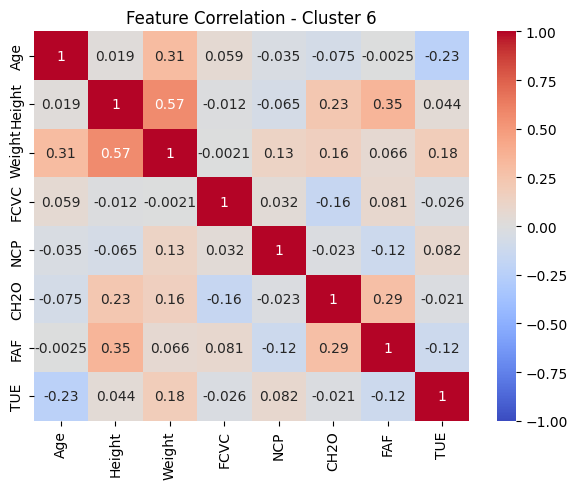

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# focus on continuous features only
features = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

# plot cluster-specific correlation matrices
for cluster_id in sorted(df["Cluster"].unique()):
    cluster_df = df[df["Cluster"] == cluster_id][features]
    corr = cluster_df.corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Feature Correlation - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()


## **Cluster Summary**

In [12]:
cluster_summary = df.groupby("Cluster").mean(numeric_only=True).round(2)

# obesity composition
obesity_counts = pd.crosstab(df["Cluster"], df["NObeyesdad"])

# output summaries
for cluster_id in sorted(df["Cluster"].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"Size: {len(df[df['Cluster'] == cluster_id])}")
    print("Obesity Composition:")
    print(obesity_counts.loc[cluster_id])
    print("Feature Means:")
    print(cluster_summary.loc[cluster_id])



--- Cluster 0 ---
Size: 281
Obesity Composition:
NObeyesdad
Insufficient_Weight     2
Normal_Weight          14
Obesity_Type_I         84
Obesity_Type_II        57
Obesity_Type_III        0
Overweight_Level_I     48
Overweight_Level_II    76
Name: 0, dtype: int64
Feature Means:
Age       36.85
Height     1.68
Weight    85.86
FCVC       2.37
NCP        2.52
CH2O       1.81
FAF        0.94
TUE        0.21
Name: 0, dtype: float64

--- Cluster 1 ---
Size: 283
Obesity Composition:
NObeyesdad
Insufficient_Weight    88
Normal_Weight          62
Obesity_Type_I         41
Obesity_Type_II         0
Obesity_Type_III        0
Overweight_Level_I     55
Overweight_Level_II    37
Name: 1, dtype: int64
Feature Means:
Age       20.77
Height     1.76
Weight    72.59
FCVC       2.42
NCP        3.13
CH2O       2.39
FAF        2.19
TUE        0.93
Name: 1, dtype: float64

--- Cluster 2 ---
Size: 203
Obesity Composition:
NObeyesdad
Insufficient_Weight      0
Normal_Weight            6
Obesity_Type_I       

7 Distinct Cluster Profiles Made

i have a quick description for each one

Cluster 0
- Transitional group with borderline risk --> they have weak health habits
- Even mix of Insufficient, Normal, Overweight I/II, and Obesity I
- Intervention would probably work preventatively

Cluster 1
- 95%+ Obesity Type III
- Very high weight (119 kg), high food control (FCVC = 3.00), full meals (NCP = 3), good water intake
- Still low activity (FAF = 0.65)
- This cluster seems to be made of people with sevrre obesity that report healthy behaviors but are likely underexercising or face an actual health issue (maybe metabolic issues? suggests intervention isn't enough and they likely need medical treatment)
- Surprisingly, older individuals in this cluster show lower weight, height, and physical activity, suggesting possible frailty-related changes or mixed subtypes within the group.

Cluster 2
- Wide range from underweight to obesity I
- Low number of meals (NCP = 1.15), moderate weight, low FAF, weak hydration, shorter average height
- Seem to have incosistent or chaotic eating schedules (can happen in students or busy individuals); irregular lifestyle and thus intervention should target adding more structure and routine to their lives
    - this is very heavily supported by correlation matrix


Cluster 3
- Dominated by Obesity I/II, some overweight; oldest cluster
- Low physical activity (FAF = 0.94), poor hydration, moderate food control
- Classic middle-age sedentary group gaining weight over time. Suggests early-stage obesity that can be reversed with lifestyle change. Possibly working professionals with time constraints.
- has older adults with rising obesity and low exercise, but unlike Cluster 1, they're not reporting high food control (suggests a consciousness gap, not just a biological one)
  - This group may respond better to awareness campaigns or behavioral nudges.

Cluster 4
- >60% Obesity Type II, very few in lower categories
- Very high weight (112 kg), slightly higher age (25), good height, moderate food control, some physical activity (FAF = 1.03)
- Not extreme in behavior, but still heavily obese. Suggests a genetic/metabolic cluster, which would make them less responsive to basic lifestyle changes. Potential misalignment between behavior and outcome.

Cluster 5
- Majority are Insufficient or Normal Weight
- High physical activity (FAF = 2.19), highest water intake, healthy eating (NCP = 3.13, FCVC = 2.42), low weight, taller height
- Healthiest cluster, may represent athletes, students, or fitness-conscious individuals. No intervention needed.

Cluster 6
- Dominated by Insufficient and Normal Weight
- Very low weight (59.9 kg), low activity, moderate food control, but low hydration and screen time
- Possibly represents underweight or inactive individuals, could be at nutritional risk even without obesity. Suggests subtle form of vulnerability despite healthy label.


## **PCA**

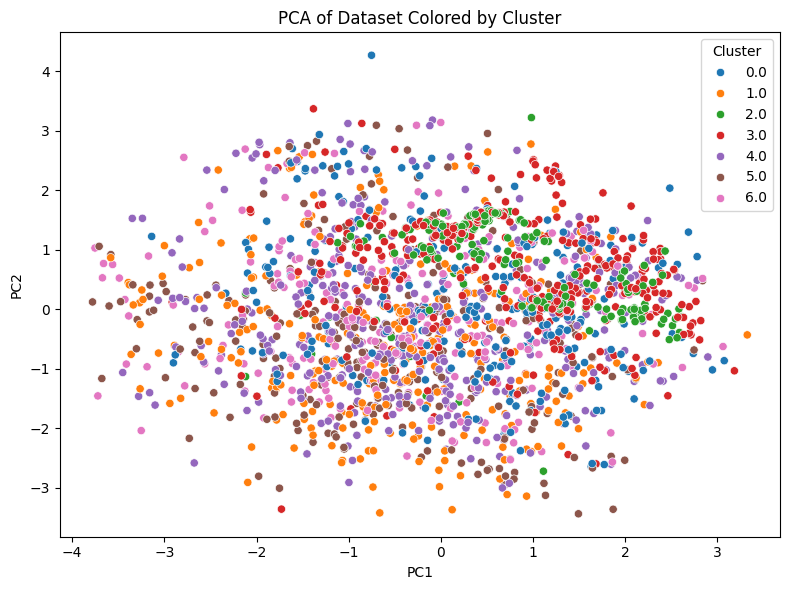

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features only (excluding Cluster and target label)
X_clustered = df.drop(columns=["NObeyesdad", "Cluster"])
X_clustered = pd.get_dummies(X_clustered, drop_first=True)

# Scale numeric features
from sklearn.preprocessing import StandardScaler
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
X_clustered[numerical_cols] = StandardScaler().fit_transform(X_clustered[numerical_cols])

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_clustered)

# Plot PCA
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
pca_df["Cluster"] = df["Cluster"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10")
plt.title("PCA of Dataset Colored by Cluster")
plt.tight_layout()
plt.show()


## **t-SNE**

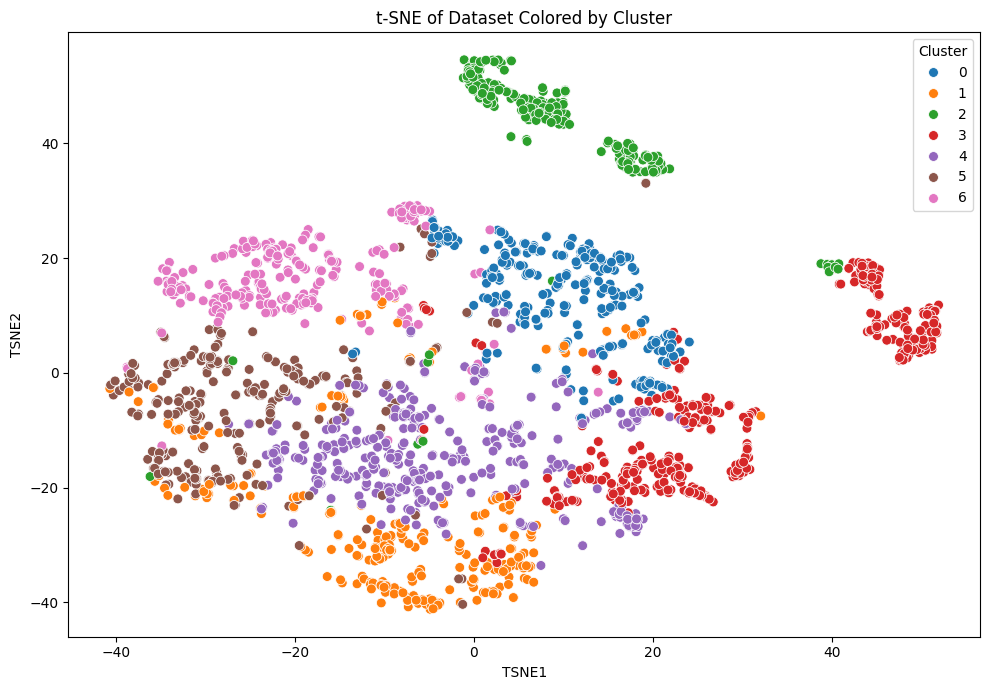

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
df["TSNE1"] = tsne_result[:, 0]
df["TSNE2"] = tsne_result[:, 1]

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="Cluster", palette="tab10", s=50)
plt.title("t-SNE of Dataset Colored by Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


## **Rerun Everything with 9 Clusters**

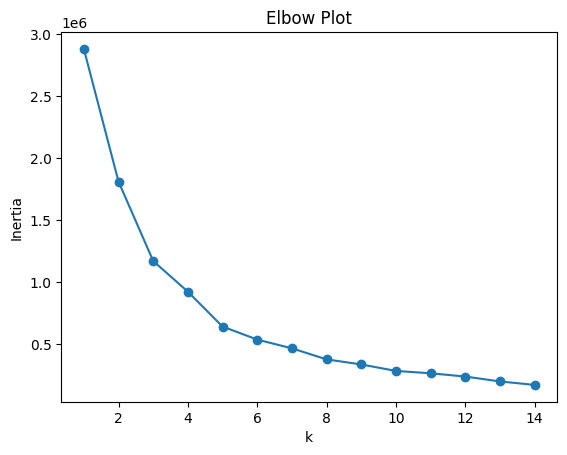

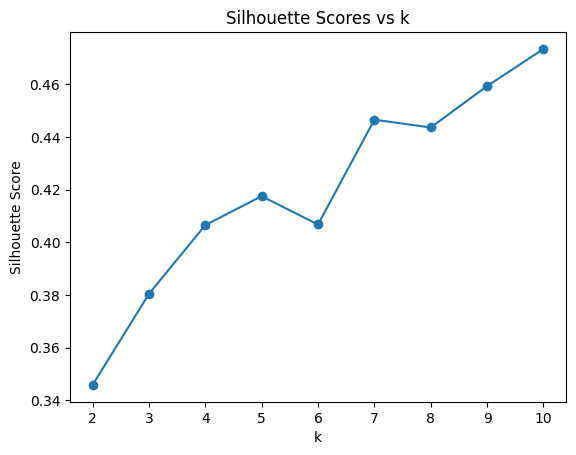

Cluster
1    317
0    293
5    292
2    256
4    227
3    225
7    172
8    160
6    145
Name: count, dtype: int64
['yes' 'no']
family_history_with_overweight
yes    1722
no      365
Name: count, dtype: int64


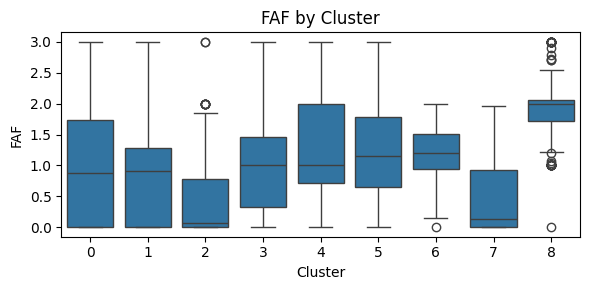

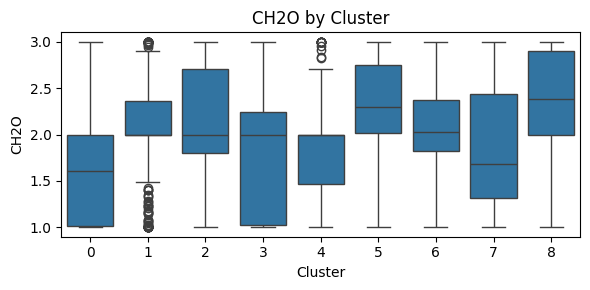

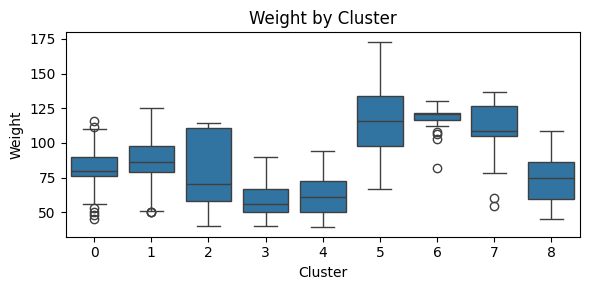

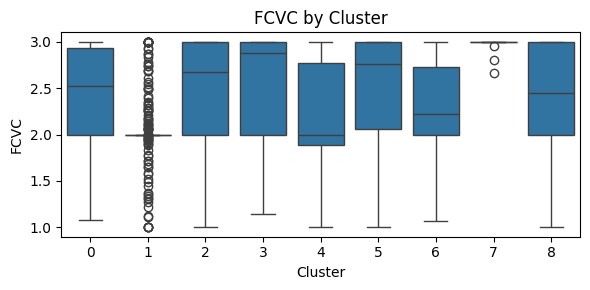

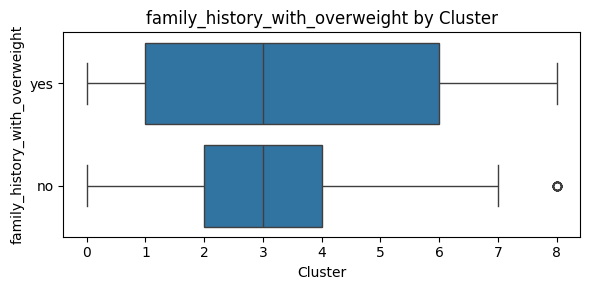

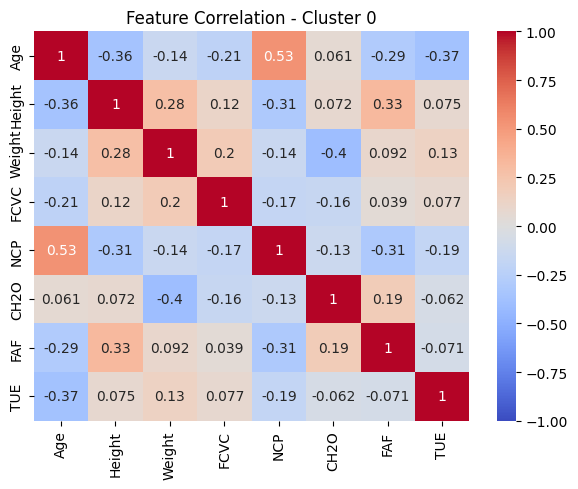

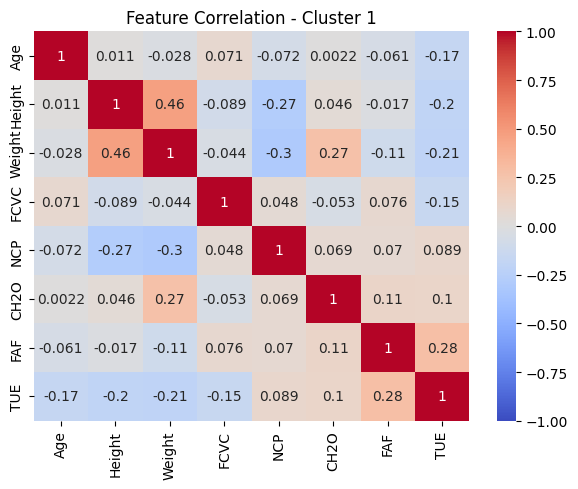

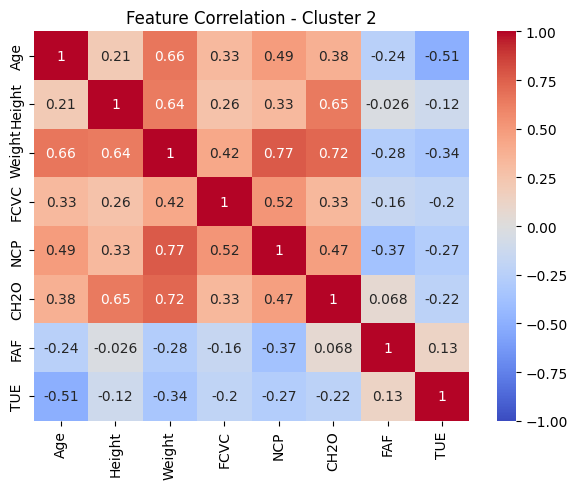

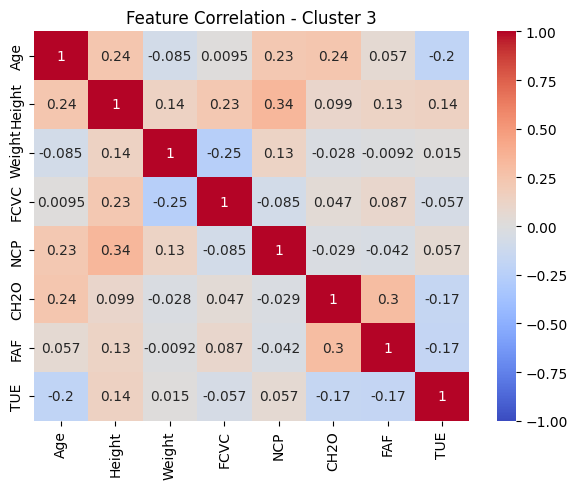

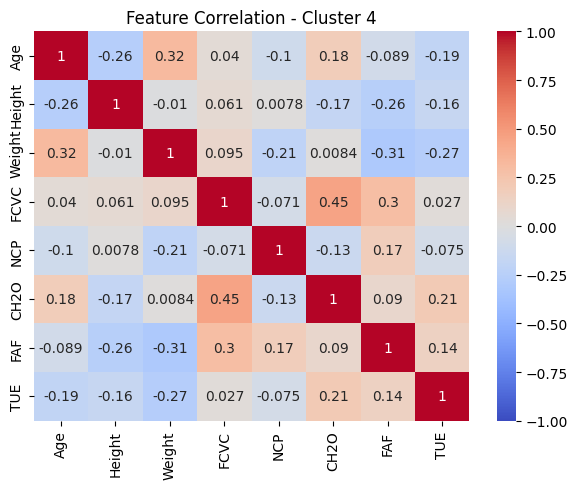

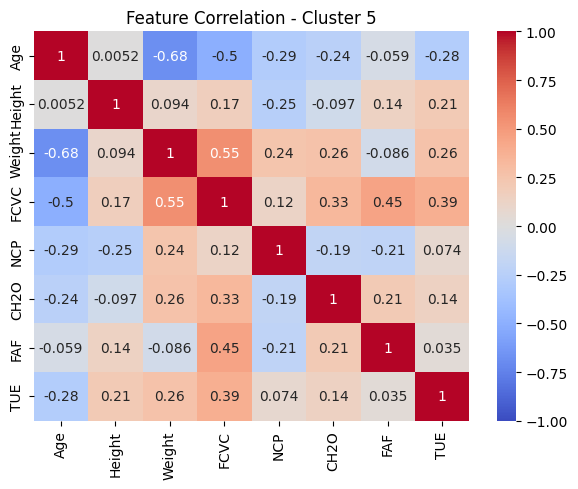

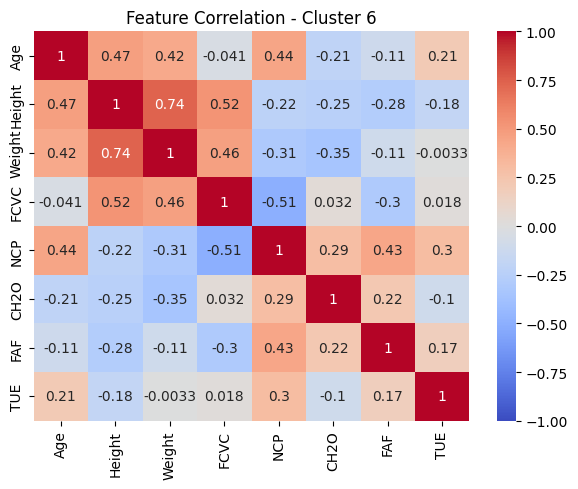

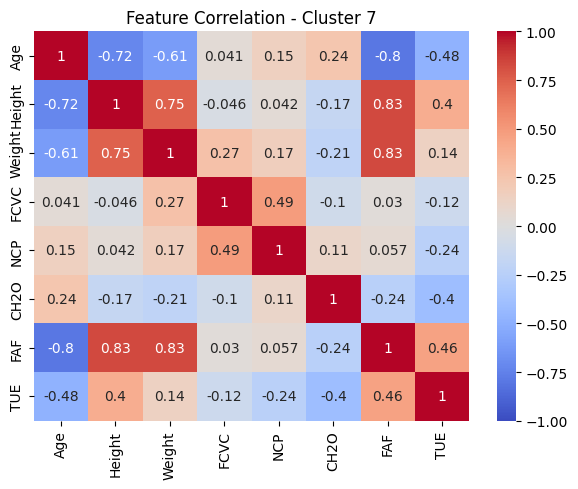

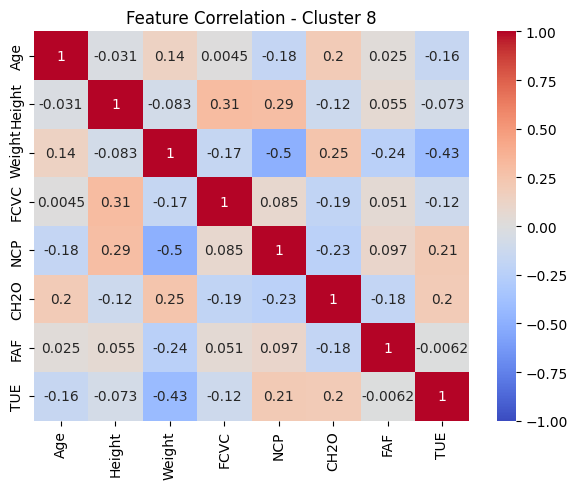


--- Cluster 0 ---
Size: 293
Obesity Composition:
NObeyesdad
Insufficient_Weight     0
Normal_Weight          28
Obesity_Type_I         64
Obesity_Type_II        69
Obesity_Type_III        0
Overweight_Level_I     69
Overweight_Level_II    63
Name: 0, dtype: int64
Feature Means:
Age       32.87
Height     1.66
Weight    82.62
FCVC       2.47
NCP        2.16
CH2O       1.65
FAF        0.93
TUE        0.36
TSNE1    -13.15
TSNE2      6.60
Name: 0, dtype: float64

--- Cluster 1 ---
Size: 317
Obesity Composition:
NObeyesdad
Insufficient_Weight     10
Normal_Weight           40
Obesity_Type_I         118
Obesity_Type_II          1
Obesity_Type_III         0
Overweight_Level_I      48
Overweight_Level_II    100
Name: 1, dtype: int64
Feature Means:
Age       22.020000
Height     1.750000
Weight    87.460000
FCVC       2.060000
NCP        2.730000
CH2O       2.070000
FAF        0.950000
TUE        1.100000
TSNE1     17.889999
TSNE2     -0.990000
Name: 1, dtype: float64

--- Cluster 2 ---
Size: 

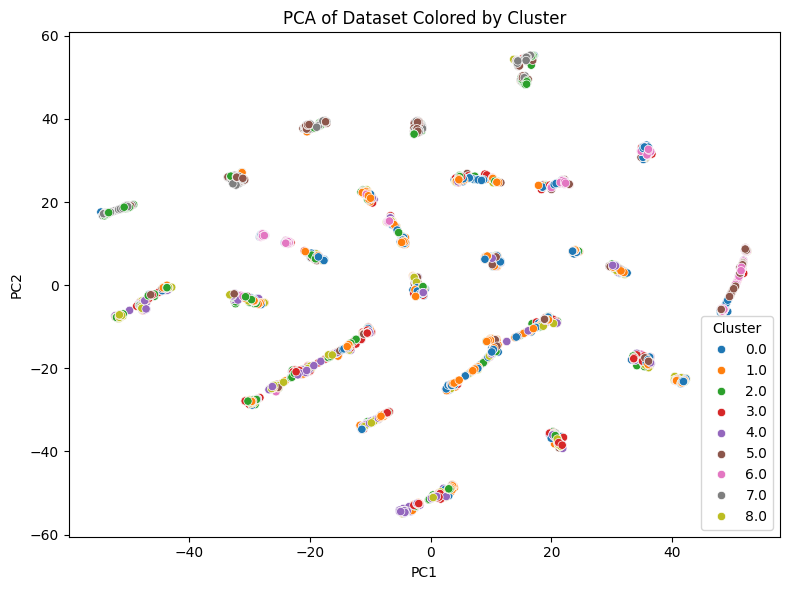

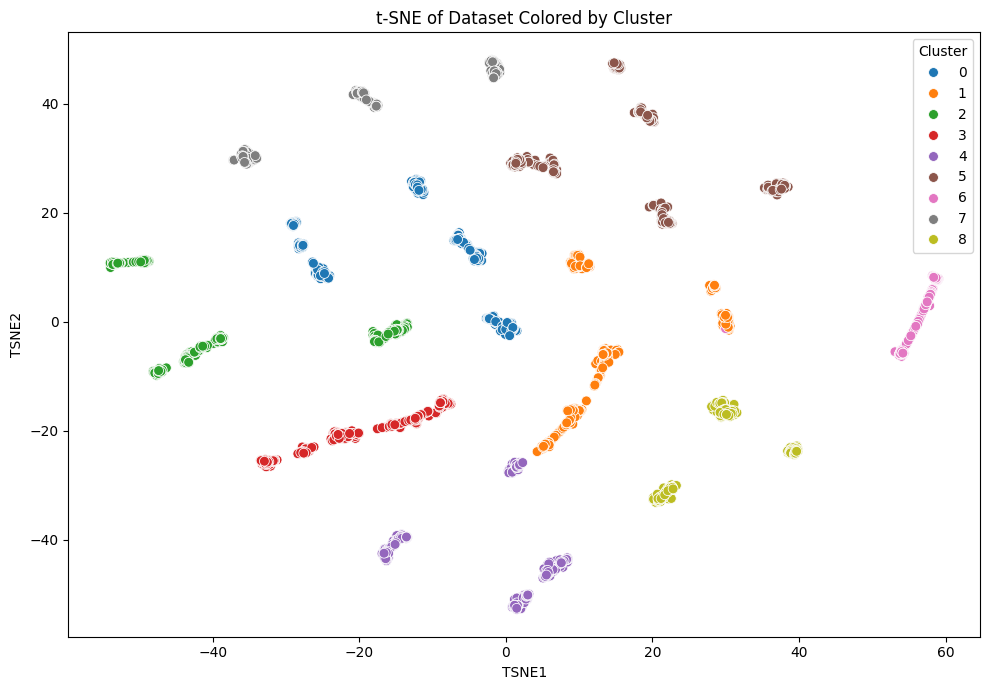

In [19]:
#just an fyi this is the exact same code as before copied and pasted into one big code block and with the cluster # modified

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# prepare data
X_scaled = df.drop(columns=["NObeyesdad"])
X_scaled = pd.get_dummies(X_scaled, drop_first=True)

# scale numeric features only
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
X_scaled[numerical_cols] = StandardScaler().fit_transform(X_scaled[numerical_cols])

#elbow plot (for determining ideal cluster group #)
inertias = []
for k in range(1, 15):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(1, 15), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

#k-means silhouette score plot (to verify)
from sklearn.metrics import silhouette_score
scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=20).fit(X_scaled)
    scores.append(silhouette_score(X_scaled, km.labels_))

plt.plot(range(2, 11), scores, marker='o')
plt.title("Silhouette Scores vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()


# run k-means
kmeans = KMeans(n_clusters=9, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# attach cluster labels to df & prview
df["Cluster"] = clusters
print(df["Cluster"].value_counts())


numeric_df = df.select_dtypes(include="number")
cluster_summary = numeric_df.groupby("Cluster").mean().round(2)
cluster_summary.T

print(df["family_history_with_overweight"].unique())
print(df["family_history_with_overweight"].value_counts(dropna=False))


import seaborn as sns
import matplotlib.pyplot as plt

key_vars = ["FAF", "CH2O", "Weight", "FCVC", "family_history_with_overweight"]

for var in key_vars:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, x="Cluster", y=var)
    plt.title(f"{var} by Cluster")
    plt.tight_layout()
    plt.show()

pd.crosstab(df["Cluster"], df["NObeyesdad"])

# focus on continuous features only
features = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

# plot cluster-specific correlation matrices
for cluster_id in sorted(df["Cluster"].unique()):
    cluster_df = df[df["Cluster"] == cluster_id][features]
    corr = cluster_df.corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Feature Correlation - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()


cluster_summary = df.groupby("Cluster").mean(numeric_only=True).round(2)

# obesity composition
obesity_counts = pd.crosstab(df["Cluster"], df["NObeyesdad"])

# output summaries
for cluster_id in sorted(df["Cluster"].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"Size: {len(df[df['Cluster'] == cluster_id])}")
    print("Obesity Composition:")
    print(obesity_counts.loc[cluster_id])
    print("Feature Means:")
    print(cluster_summary.loc[cluster_id])


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features only (excluding Cluster and target label)
X_clustered = df.drop(columns=["NObeyesdad", "Cluster"])
X_clustered = pd.get_dummies(X_clustered, drop_first=True)

# Scale numeric features
from sklearn.preprocessing import StandardScaler
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
X_clustered[numerical_cols] = StandardScaler().fit_transform(X_clustered[numerical_cols])

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_clustered)

# Plot PCA
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
pca_df["Cluster"] = df["Cluster"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10")
plt.title("PCA of Dataset Colored by Cluster")
plt.tight_layout()
plt.show()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
df["TSNE1"] = tsne_result[:, 0]
df["TSNE2"] = tsne_result[:, 1]

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="Cluster", palette="tab10", s=50)
plt.title("t-SNE of Dataset Colored by Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()








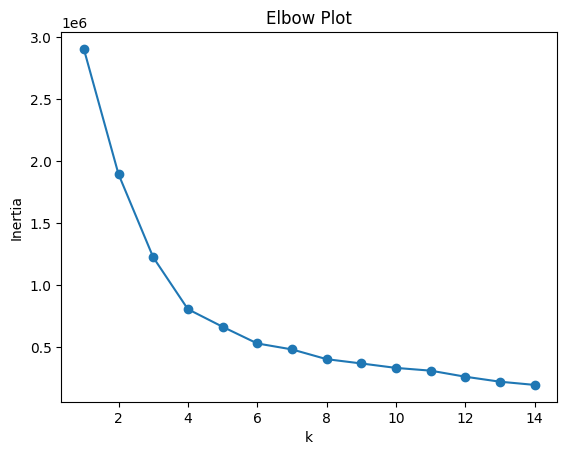

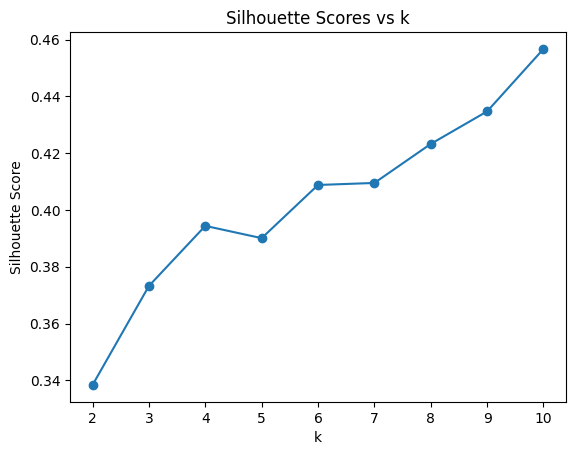

Cluster
0    321
5    305
1    301
7    287
3    225
2    183
9    126
8    114
6    113
4    112
Name: count, dtype: int64
['yes' 'no']
family_history_with_overweight
yes    1722
no      365
Name: count, dtype: int64


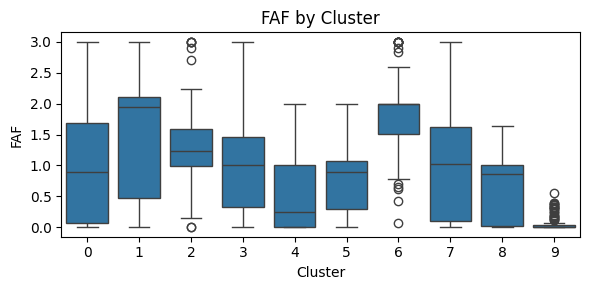

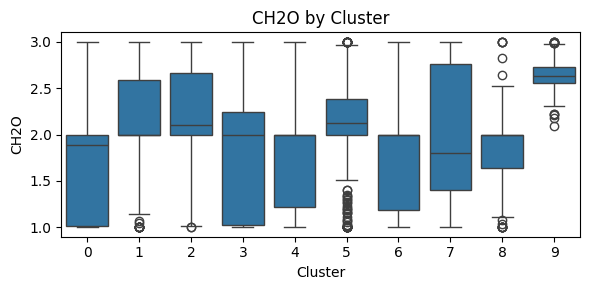

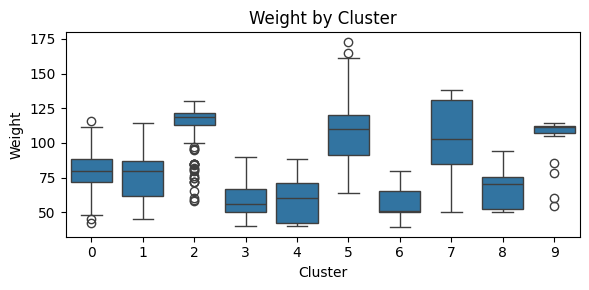

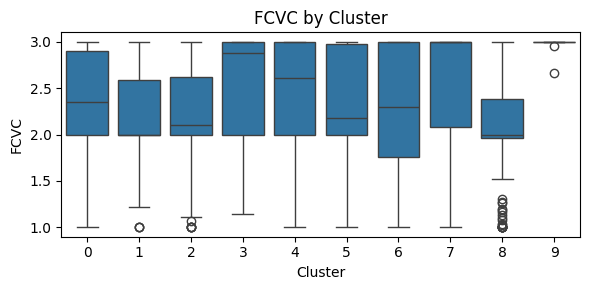

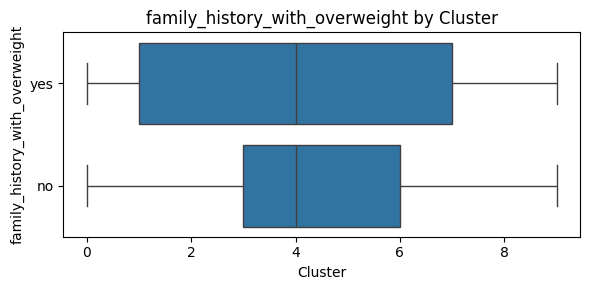

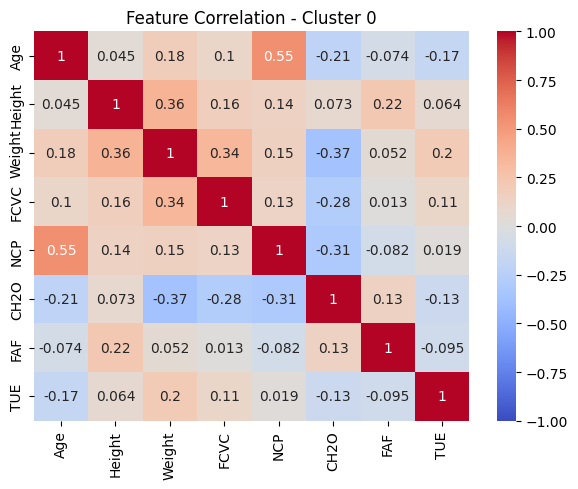

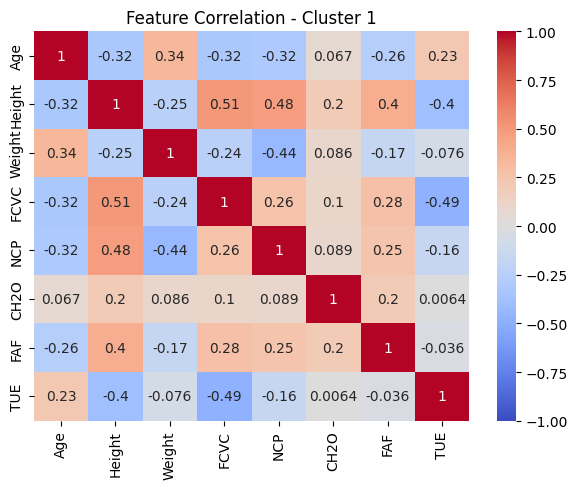

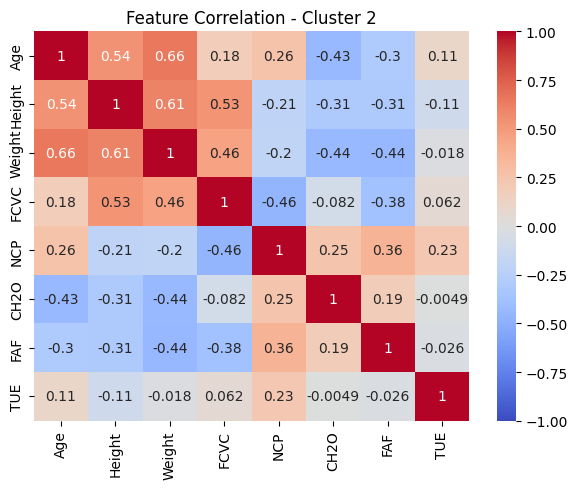

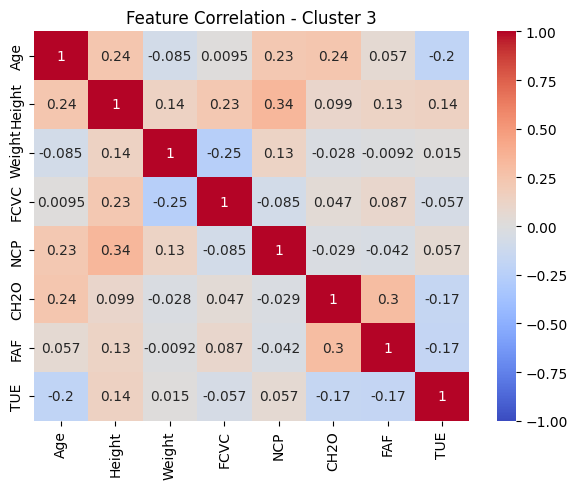

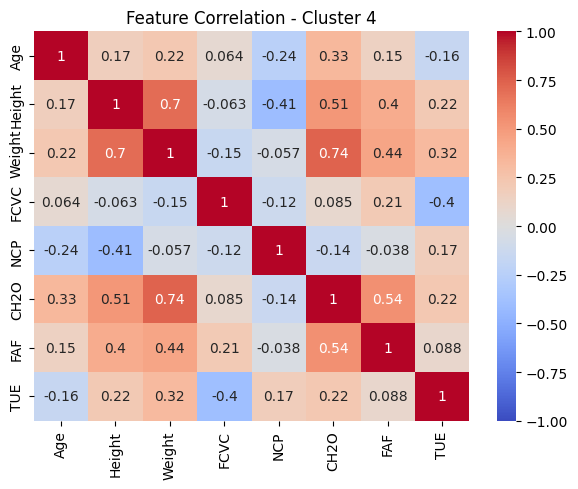

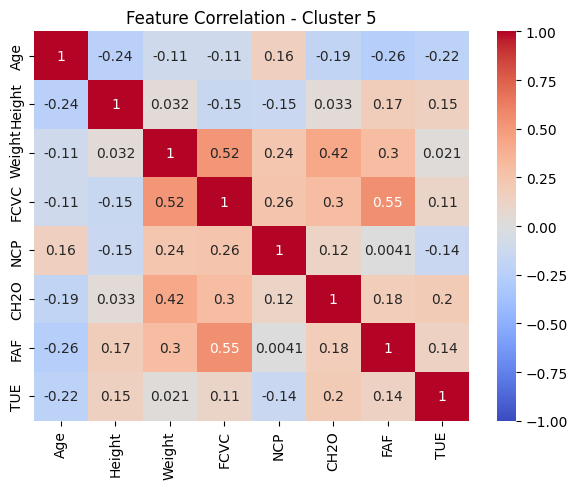

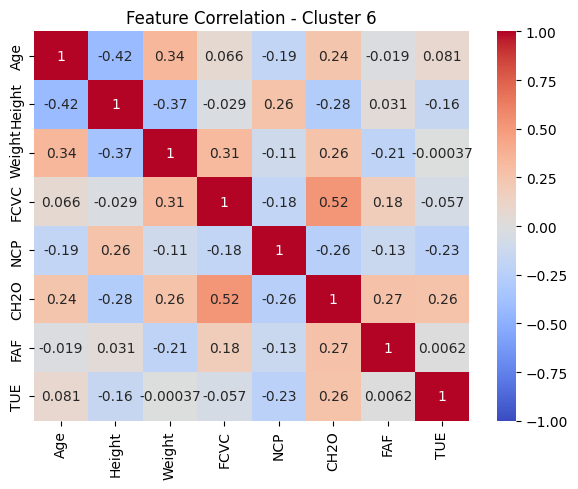

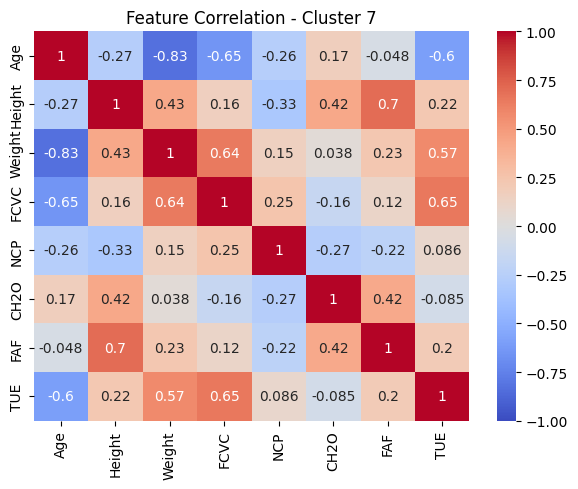

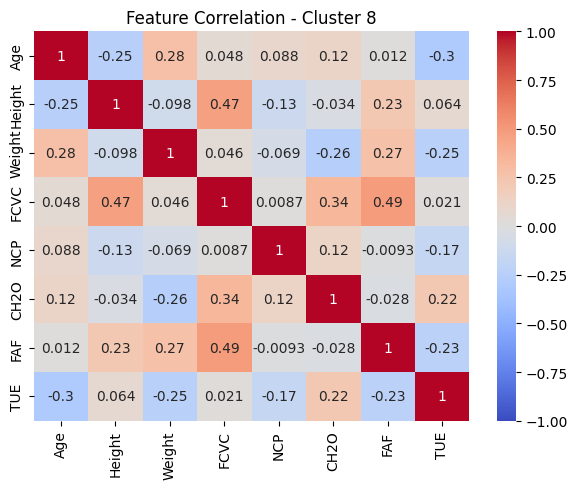

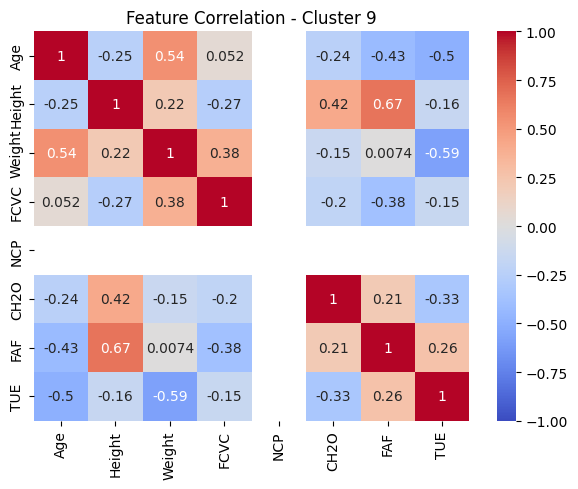


--- Cluster 0 ---
Size: 321
Obesity Composition:
NObeyesdad
Insufficient_Weight     3
Normal_Weight          40
Obesity_Type_I         53
Obesity_Type_II        69
Obesity_Type_III        0
Overweight_Level_I     78
Overweight_Level_II    78
Name: 0, dtype: int64
Feature Means:
Age       29.51
Height     1.66
Weight    80.75
FCVC       2.42
NCP        1.81
CH2O       1.72
FAF        0.95
TUE        0.35
TSNE1    -14.57
TSNE2      5.43
Name: 0, dtype: float64

--- Cluster 1 ---
Size: 301
Obesity Composition:
NObeyesdad
Insufficient_Weight    68
Normal_Weight          52
Obesity_Type_I         61
Obesity_Type_II         1
Obesity_Type_III        0
Overweight_Level_I     50
Overweight_Level_II    69
Name: 1, dtype: int64
Feature Means:
Age       20.630000
Height     1.750000
Weight    77.080000
FCVC       2.260000
NCP        3.150000
CH2O       2.200000
FAF        1.510000
TUE        1.040000
TSNE1     18.420000
TSNE2    -16.049999
Name: 1, dtype: float64

--- Cluster 2 ---
Size: 183
Obe

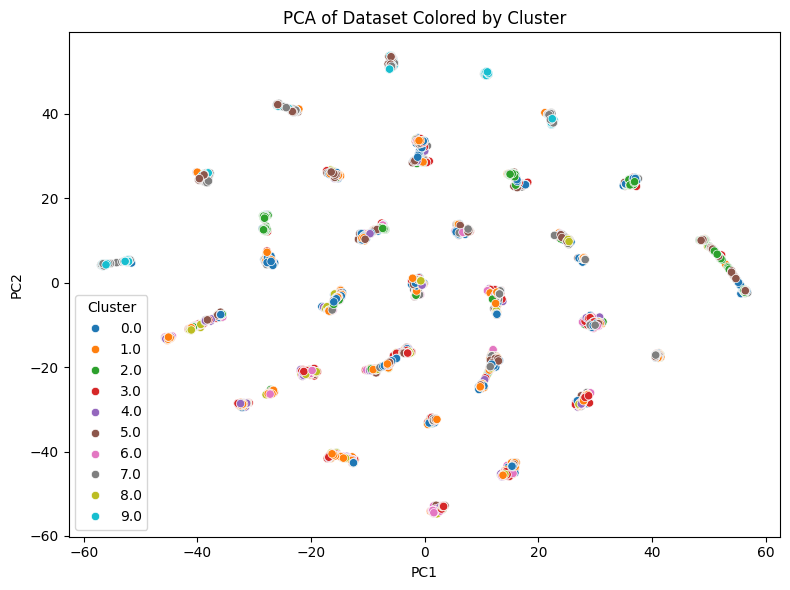

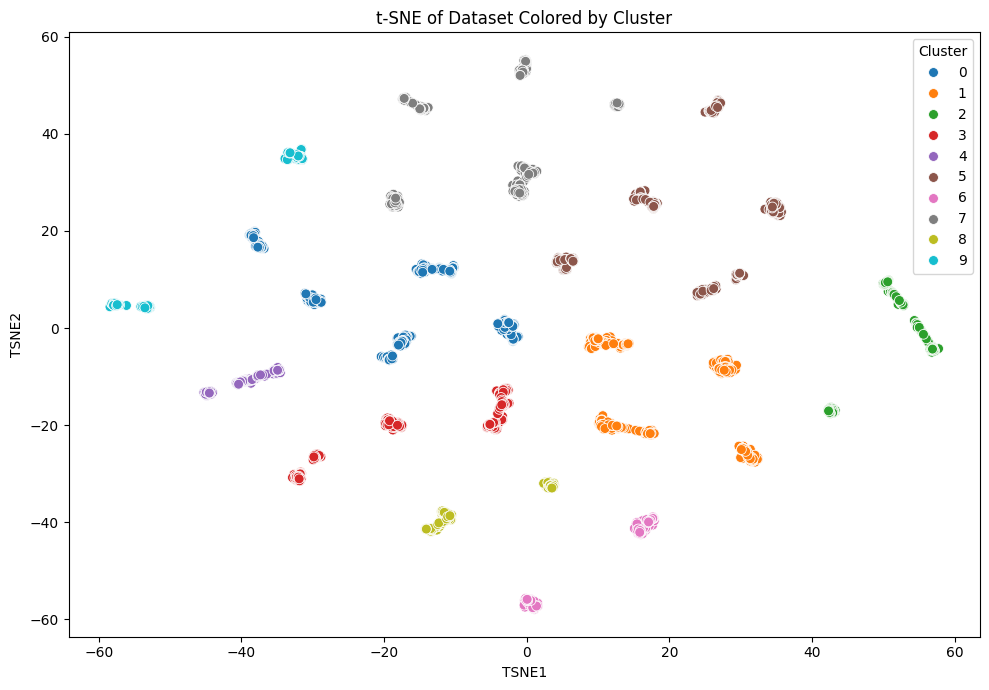

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# prepare data
X_scaled = df.drop(columns=["NObeyesdad"])
X_scaled = pd.get_dummies(X_scaled, drop_first=True)

#slightly scale down weight
X_scaled["Weight"] *= 0.5


# scale numeric features only
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
X_scaled[numerical_cols] = StandardScaler().fit_transform(X_scaled[numerical_cols])

#elbow plot (for determining ideal cluster group #)
inertias = []
for k in range(1, 15):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(range(1, 15), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

#k-means silhouette score plot (to verify)
from sklearn.metrics import silhouette_score
scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=20).fit(X_scaled)
    scores.append(silhouette_score(X_scaled, km.labels_))

plt.plot(range(2, 11), scores, marker='o')
plt.title("Silhouette Scores vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()


# run k-means
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# attach cluster labels to df & prview
df["Cluster"] = clusters
print(df["Cluster"].value_counts())


numeric_df = df.select_dtypes(include="number")
cluster_summary = numeric_df.groupby("Cluster").mean().round(2)
cluster_summary.T

print(df["family_history_with_overweight"].unique())
print(df["family_history_with_overweight"].value_counts(dropna=False))


import seaborn as sns
import matplotlib.pyplot as plt

key_vars = ["FAF", "CH2O", "Weight", "FCVC", "family_history_with_overweight"]

for var in key_vars:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, x="Cluster", y=var)
    plt.title(f"{var} by Cluster")
    plt.tight_layout()
    plt.show()

pd.crosstab(df["Cluster"], df["NObeyesdad"])

# focus on continuous features only
features = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

# plot cluster-specific correlation matrices
for cluster_id in sorted(df["Cluster"].unique()):
    cluster_df = df[df["Cluster"] == cluster_id][features]
    corr = cluster_df.corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Feature Correlation - Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()


cluster_summary = df.groupby("Cluster").mean(numeric_only=True).round(2)

# obesity composition
obesity_counts = pd.crosstab(df["Cluster"], df["NObeyesdad"])

# output summaries
for cluster_id in sorted(df["Cluster"].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"Size: {len(df[df['Cluster'] == cluster_id])}")
    print("Obesity Composition:")
    print(obesity_counts.loc[cluster_id])
    print("Feature Means:")
    print(cluster_summary.loc[cluster_id])


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features only (excluding Cluster and target label)
X_clustered = df.drop(columns=["NObeyesdad", "Cluster"])
X_clustered = pd.get_dummies(X_clustered, drop_first=True)

# Scale numeric features
from sklearn.preprocessing import StandardScaler
numerical_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
X_clustered[numerical_cols] = StandardScaler().fit_transform(X_clustered[numerical_cols])

# PCA to 2 components
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_clustered)

# Plot PCA
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
pca_df["Cluster"] = df["Cluster"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10")
plt.title("PCA of Dataset Colored by Cluster")
plt.tight_layout()
plt.show()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
df["TSNE1"] = tsne_result[:, 0]
df["TSNE2"] = tsne_result[:, 1]

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue="Cluster", palette="tab10", s=50)
plt.title("t-SNE of Dataset Colored by Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()






